# Notebook to create OF figures for manuscrip.

Imports

In [2]:
%matplotlib inline

from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

## added TreeMazeanalyses folder using the following command
## conda develop /home/alexgonzalez/Documents/TreeMazeAnalyses2
import TreeMazeAnalyses2.Utils.robust_stats as rs

from TreeMazeAnalyses2.Analyses.subject_info import SubjectInfo, SubjectSessionInfo
from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs

from TreeMazeAnalyses2.Analyses import cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

Defaults

In [5]:
subjects = ['Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
analyses_colors = sns.color_palette(palette='deep', as_cmap=True)

gd_results_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Results_Summary/")
local_results_path = Path("/mnt/Data_HD2T/SummaryData/")

fig5_path = Path("/home/alexgonzalez/google-drive/TreeMazeProject/Figures/Fig5/")

units_table_fn = "all_units_table.csv"
metric_scores_fn = 'of_metric_scores_summary_table.csv'
model_scores_fn = 'of_model_scores_summary_table.csv'

Load data

In [6]:
metric_scores = pd.read_csv(local_results_path / metric_scores_fn, index_col=0)
model_scores = pd.read_csv(local_results_path / model_scores_fn, index_col=0)
unit_table = pd.read_csv(local_results_path / units_table_fn, index_col=0)

## correct scores tables for erronous session

In [7]:
invalid_sessions = ['Li_OF_080718'] ## mislabeled session

for session in invalid_sessions:
    unit_idx = unit_table[unit_table.session==session].unique_cl_name
    metric_scores.loc[metric_scores.cl_name.isin(unit_idx), 'session_valid'] = False
    model_scores.loc[model_scores.cl_name.isin(unit_idx), 'session_valid'] = False

In [8]:
metric_scores[metric_scores.cl_name.isin(unit_idx)] 

,unit_id,subject,session,session_pct_cov,session_valid,session_unit_id,unit_type,tt,tt_cl,cl_name,analysis_type,score,sig
3280,656,Li,Li_OF_080718,0.28,False,0,cell,8,6,Li_OF_080718-tt8_d18.75_cl6,speed,0.072156,1.0
3281,657,Li,Li_OF_080718,0.28,False,1,cell,9,3,Li_OF_080718-tt9_d21.75_cl3,speed,-0.016454,1.0
3282,658,Li,Li_OF_080718,0.28,False,2,cell,9,8,Li_OF_080718-tt9_d21.75_cl8,speed,-0.046637,1.0
3283,659,Li,Li_OF_080718,0.28,False,3,cell,9,12,Li_OF_080718-tt9_d21.75_cl12,speed,0.022148,1.0
3284,660,Li,Li_OF_080718,0.28,False,4,cell,14,9,Li_OF_080718-tt14_d19.0_cl9,speed,0.010697,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3385,673,Li,Li_OF_080718,0.28,False,17,mua,14,11,Li_OF_080718-tt14_d19.0_cl11,stability,0.954826,0.0
3386,674,Li,Li_OF_080718,0.28,False,18,mua,14,12,Li_OF_080718-tt14_d19.0_cl12,stability,0.911813,0.0
3387,675,Li,Li_OF_080718,0.28,False,19,mua,14,13,Li_OF_080718-tt14_d19.0_cl13,stability,0.939846,0.0
3388,676,Li,Li_OF_080718,0.28,False,20,mua,15,12,Li_OF_080718-tt15_d23.25_cl12,stability,0.746654,0.0


In [34]:
unit_table[unit_table['unique_cl_name'].isin(metric_scores.cl_name.unique())]

,subject_cl_id,subject,session,task,date,subsession,tt,depth,unique_cl_name,session_cl_id,...,subject_cl_match_lib_id,snr,fr,isi_viol_rate,cl_id,cl_match_con_id,cl_match_lib_id,task2,match_lib_multi_task_id,match_con_multi_task_id
2,2,Li,Li_OF_052818,OF,52818,0,7,17.250,Li_OF_052818-tt7_d17.25_cl8,8,...,39.0,5.09,13.56,1.13,2,43.0,39.0,OF,-1,-1
3,3,Li,Li_OF_052818,OF,52818,0,8,16.250,Li_OF_052818-tt8_d16.25_cl4,4,...,44.0,10.08,2.95,0.44,3,48.0,44.0,OF,-1,-1
4,4,Li,Li_OF_052818,OF,52818,0,8,16.250,Li_OF_052818-tt8_d16.25_cl18,18,...,52.0,6.60,33.03,0.54,4,50.0,52.0,OF,-1,-1
5,5,Li,Li_OF_052818,OF,52818,0,7,17.250,Li_OF_052818-tt7_d17.25_cl0,0,...,NaN,2.78,7.05,2.44,5,NaN,NaN,OF,-1,-1
6,6,Li,Li_OF_052818,OF,52818,0,7,17.250,Li_OF_052818-tt7_d17.25_cl1,1,...,NaN,2.74,14.54,2.67,6,NaN,NaN,OF,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4459,73,Mi,Mi_OF_021220,OF,21220,0,12,16.125,Mi_OF_021220-tt12_d16.125_cl20,20,...,8.0,8.11,25.24,0.11,4459,964.0,858.0,OF,-1,-1
4460,74,Mi,Mi_OF_021220,OF,21220,0,12,16.125,Mi_OF_021220-tt12_d16.125_cl10,10,...,NaN,6.75,8.17,0.51,4460,NaN,NaN,OF,-1,-1
4461,75,Mi,Mi_OF_021720,OF,21720,0,14,16.375,Mi_OF_021720-tt14_d16.375_cl1,1,...,11.0,12.38,4.92,0.00,4461,967.0,861.0,OF,-1,-1
4462,76,Mi,Mi_OF_021720,OF,21720,0,14,16.375,Mi_OF_021720-tt14_d16.375_cl0,0,...,NaN,20.18,0.42,0.00,4462,NaN,NaN,OF,-1,-1


## select example cell

In [5]:
analyses=['speed','hd','border','grid', 'stability']
@interact(analysis_type=analyses, unit_type=['cell', 'mua', None], thr=widgets.FloatSlider(min=-1, max=1, step=0.02))
def metric_filter_units(analysis_type, thr, unit_type=None):
    if unit_type is None:
        sub_table = metric_scores.loc[ (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr) 
                                      & (metric_scores.session_valid)]
    else:
        sub_table = metric_scores.loc[ (metric_scores.unit_type==unit_type) 
                                      & (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr)
                                      & (metric_scores.session_valid)]
    return sub_table.sort_values(by=['score'], ascending=False)
        

interactive(children=(Dropdown(description='analysis_type', options=('speed', 'hd', 'border', 'grid', 'stabili…

In [6]:
@interact(model=['speed','hd','border','grid', 'pos'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'n_err'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)


interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos'), value='s…

Helper functions

In [7]:
label_fontsize = 14

def get_bin_ang_fr(track_data, fr, bin_step= np.pi/18, min_speed=3):
    hd = track_data['hd']
    sp = track_data['sp']
    
    speed_valid_idx = sp>=min_speed 
    hd2 = hd[speed_valid_idx]
    fr2 = fr[speed_valid_idx]
    
    res, ang_fr, ang_bin_centers, ang_bin_edges = spatial_funcs.get_angle_stats(hd2, bin_step, weights=fr2)
    res['vec_len'] = np.abs(np.mean(ang_fr*np.exp(ang_bin_centers*1j)))
    res['ang_fr'] = ang_fr
    res['ang_bin_centers'] = ang_bin_centers
    res['ang_bin_edges'] = ang_bin_edges
    return res

def get_bin_sp_fr(track_data, fr, bin_step=3, min_speed=0, max_speed=80):
    sp = track_data['sp']
    
    sp_bin_edges = np.arange(min_speed,max_speed, bin_step)
    sp_design_mat, sp_bin_idx, valid_samps = spatial_funcs.get_speed_encoding_features(sp, sp_bin_edges)
    sp_bin_centers = sp_bin_edges[:-1] + bin_step/2
    
    fr2 = fr[valid_samps]
    
    n_bins = len(sp_bin_centers)
    sp_fr_m = np.zeros(n_bins)
    sp_fr_s = np.zeros(n_bins)
    for sp_idx in range(n_bins): 
        sp_fr_m[sp_idx] = np.nanmean(fr2[sp_design_mat[:,sp_idx]==1])
        sp_fr_s[sp_idx] = stats.sem(fr2[sp_design_mat[:,sp_idx]==1])
        
    r = stats.spearmanr(sp_fr_m, sp_bin_centers)
    res = {'r':r[0], 'p_val': r[1], 'sp_fr_m': sp_fr_m, 'sp_fr_s': sp_fr_s, 'sp_bin_centers':sp_bin_centers, 'sp_bin_edges': sp_bin_edges}
    
    return res

def colorline(
    x, y, z=None, colors=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0,ax=None):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])

    z = np.asarray(z)

    segments = make_segments(x, y)
    if colors is None:
        lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    else:
        lc = mcoll.LineCollection(segments, colors=colors,
                              linewidth=linewidth, alpha=alpha,zorder=1)
    if ax is None:
        ax = plt.gca()
    ax.add_collection(lc)

    return lc

def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def getColBar(ax, values, cmap='magma', cax_pos=[0.85,0,0.05,0.2]):

    pos = ax.get_position()
    cax = plt.axes([pos.x0+pos.width*cax_pos[0],pos.y0+cax_pos[1],pos.width*cax_pos[2],pos.height*cax_pos[3]])
    
    cMap=mpl.colors.ListedColormap(sns.color_palette(cmap,50))
    vmax = np.around(values.max(),1)
    vmin = np.around(values.min(),1)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax, clip=True)
    mapper = mpl.cm.ScalarMappable(norm=norm, cmap=cMap)

    mapper.set_array([])
    cbar = plt.colorbar(mapper,ticks=[vmin,vmax],cax=cax)
    cax.yaxis.set_tick_params(right=False)
    #cax.set_frame_on(False)
    for pos in ['right', 'top', 'bottom', 'left']:
        cax.spines[pos].set_visible(False)

    cax.axes.tick_params(pad=-3)

    return cax
    
def plot_sp_fr(sp_bins, sp_fr_m, sp_fr_s, ax):
    ax.plot(sp_bins,sp_fr_m,linewidth=3)
    ax.fill_between(sp_bins, sp_fr_m - sp_fr_s, sp_fr_m + sp_fr_s, alpha=0.5)
    ax.set_xlabel(' Speed [cm/s]')
    ax.set_ylabel(' FR [sp/s]')
    ax.set_ylim([np.nanmin(sp_fr_m-sp_fr_s)*0.9, np.nanmax(sp_fr_m+sp_fr_s)*1.1])
    ax.set_xlim([0,81])
    ax.set_title('Speed Tunning', fontsize=label_fontsize)
    return ax
    
def plot_ang_fr(ang_bins,ang_fr, mean_ang, vec_len ,ax, cmap='magma_r'):
    colors = plt.cm.get_cmap(cmap)(ang_fr/ang_fr.max())

    ax.scatter(ang_bins,ang_fr,color=colors,zorder=2)
    colorline( np.append(ang_bins,ang_bins[0]) ,np.append(ang_fr,ang_fr[0]),colors=np.append(colors,[colors[0]],axis=0),ax=ax)

    ax.plot([0,mean_ang],[0,vec_len],color='k',linewidth=4, solid_capstyle='round')
    ax.set_xticklabels(['E','','','','W'], fontsize=label_fontsize)

    ax.set_yticks([])
    ax.set_ylim([0,np.max(ang_fr)*1.1])
    ax.set_title('HD Tunning', fontsize=label_fontsize)

    cax=getColBar(ax, ang_fr, cmap=cmap, cax_pos=[0.95,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_xy_spks(x,y,spikes,ax):
    ax.plot(x,y,linewidth=1,color='k',alpha=0.5)
    ax.scatter(x,y,s=spikes*3,color='r',alpha=0.7)
    ax.set_aspect('equal',adjustable='box')
    ax.set_axis_off()
    ax.set_title('Traces + Spikes', fontsize=label_fontsize)
    return ax

def plot_fr_map(fr_map, ax, cmap='viridis'):
    vmin=0 
    vmax = fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    ax.set_title('FR Map', fontsize=label_fontsize)

    cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
    cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    return ax, cax

def plot_fr_map2(track_data, spikes, fr, fr_map, cl_name=None, ax=None, cbar=False, max_txt=True, cmap='viridis'):
    if ax is None:
        f,ax = plt.subplots(figsize=(4,4))
    else:
        f = ax.figure
    
    vmin, vmax = 0, fr_map.max()
    colors = plt.cm.get_cmap(cmap)(fr_map/vmax)

    ax = sns.heatmap(fr_map, xticklabels=[], yticklabels=[], cmap=cmap, 
                     vmin=0, vmax=vmax, square=True, cbar=False, ax=ax)

    ax.invert_yaxis()
    #ax.set_title('FR Map', fontsize=label_fontsize)

    if cbar:
        cax = getColBar(ax, fr_map.flatten(), cmap=cmap, cax_pos=[1.02,0,0.05,0.2])
        cax.set_ylabel(' fr', rotation='horizontal', va='center', ha='right', fontsize=label_fontsize)

    if cl_name is not None:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0-0.1,pos.y0,0.02,pos.height])
        axt.text(0,.1, cl_name, rotation=90)
        axt.set_axis_off()
        
    if max_txt:
        pos = ax.get_position()
        axt = f.add_axes([pos.x0+pos.width+0.01, pos.y0, 0.02,0.1])
        axt.text(0,.1, np.around(vmax,1), fontsize=8)
        axt.set_axis_off()
        
    return f, ax

def plot_OF(cl_name, track_data, spikes, fr, fr_map):
    
    label_fontsize = 14
    
    f = plt.figure(constrained_layout=True, figsize=(10 , 5))
    gs = f.add_gridspec(2,3)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[:, 1])
    ax[2] = f.add_subplot(gs[0, 2], projection='polar')
    ax[3] = f.add_subplot(gs[1, 2])

    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
    
    ax[1], cax = plot_fr_map(fr_map, ax[1])
     
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[2], cax = plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[2])
    
    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[3] = plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[3])

    ap = ax[2].get_position()
    pos = [ap.x0+0.03, ap.y0, ap.width*0.8, ap.height*0.75]
    ax[2].set_position(pos)
    
    ap = ax[3].get_position()
    pos = [ap.x0+0.1, ap.y0+0.1, ap.width*0.55, ap.height*0.65]
    ax[3].set_position(pos)
    
    axt = f.add_axes([0,0,0.02,1])
    axt.text(-0.2,.25, cl_name, rotation=90)
    axt.set_axis_off()
    return f, ax

def plot_OF2(cl_name, track_data, spikes, fr, fr_map):
    
    label_fontsize = 14
    
    f = plt.figure(figsize=(8,6))
    gs = f.add_gridspec(2,2)
    ax = [[]]*4
    ax[0] = f.add_subplot(gs[:, 0])
    ax[1] = f.add_subplot(gs[0, 1], projection='polar', position=[0.55, 0.55, 0.2, 0.2])
    ax[2] = f.add_subplot(gs[1, 1], position=[0.58, 0.28, 0.15, 0.2])
    
    x,y = track_data['x'],track_data['y']
    ax[0] = plot_xy_spks(x,y,spikes,ax[0])
  
    res = get_bin_ang_fr(track_data, fr)
    vec_len, mean_ang, ang_fr, ang_bin_centers = res['vec_len'], res['mean_ang'], res['ang_fr'], res['ang_bin_centers']
    ax[1], cax =plot_ang_fr(ang_bin_centers, ang_fr, mean_ang, vec_len,  ax[1])

    res = get_bin_sp_fr(track_data, fr)
    sp_bin_centers, sp_fr_m, sp_fr_s = res['sp_bin_centers'], res['sp_fr_m'], res['sp_fr_s']
    ax[2]=plot_sp_fr(sp_bin_centers, sp_fr_m, sp_fr_s, ax[2])
    
    pos = ax[0].get_position()
    axt = f.add_axes([pos.x0-0.03,pos.y0,0.02,pos.height])
#     axt = f.add_axes([0.1,0,0.02,1])
    axt.text(0,.1, cl_name, rotation=90)
    axt.set_axis_off()
    
    return f, ax

def load_cell(idx, table):
    subject, session, session_unit_id = table.loc[idx]['subject'], table.loc[idx]['session'], table.loc[idx]['session_unit_id']
    session_info = SubjectSessionInfo(subject, session)
    
    track_data = session_info.get_track_data()
    spikes = session_info.get_binned_spikes()[session_unit_id]
    fr = session_info.get_fr()[session_unit_id]
    fr_map = session_info.get_fr_maps()[session_unit_id]

    return track_data, spikes, fr, fr_map
#f,ax = plot_OF(track_data, spikes, fr, fr_maps)

In [10]:
analysis_type = 'grid'
thr = 0.2
sub_metric_table = metric_filter_units(analysis_type=analysis_type, thr=thr)

@interact(idx=sub_metric_table.index)
def plot_OF_unit(idx):

    cl_name = metric_scores.loc[idx, 'cl_name']
    f,ax = plot_OF(cl_name, *load_cell(idx, metric_scores) )
    return metric_scores[metric_scores.cl_name==cl_name]

interactive(children=(Dropdown(description='idx', options=(2879, 4476, 2788, 10839, 9473, 3139, 9690, 2771, 37…

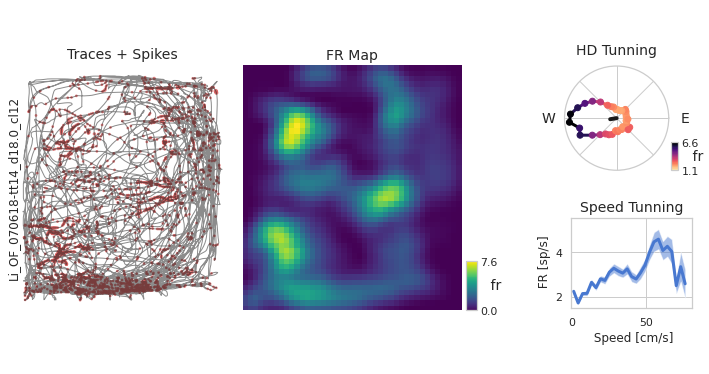

In [12]:
idx = 2879
sns.set_style("whitegrid")
cl_name = metric_scores.loc[idx, 'cl_name']
f,ax = plot_OF(cl_name, *load_cell(idx, metric_scores))
#f.savefig(fig5_path / f'OF_Metrics_{cl_name}.pdf',dpi=300, bbox_inches='tight', pad_inches=0.2)
#f.savefig(fig5_path / f'OF_Metrics_{cl_name}.svg',dpi=300, bbox_inches='tight', pad_inches=0.2)

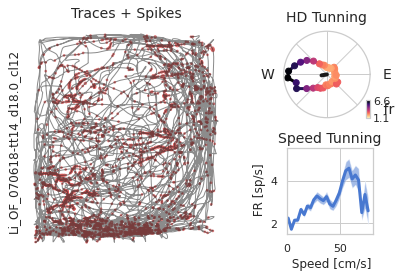

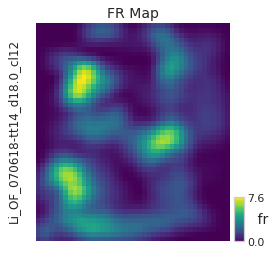

In [227]:
sns.set_style("whitegrid")
f,ax = plot_OF2(cl_name, *load_cell(idx))
f.savefig(fig5_path / f'OF_Metrics_{cl_name}_vectors.pdf', bbox_inches='tight', pad_inches=0.2)
f, ax = plot_fr_map2( *load_cell(idx))
f.savefig(fig5_path / f'OF_Metrics_{cl_name}_raster.png',dpi=300, bbox_inches='tight', pad_inches=0.2)

## Plot a few example rasters

In [554]:
model = 'speed'
thr = 0.05
model_metric='r2'
split='test'
unit_type='cell'
sub_model_table = model_filter_units(model, thr, model_metric, split, unit_type=unit_type)
sub_model_table

,unit_id,subject,session,session_unit_id,unit_type,session_pct_cov,session_valid,tt,tt_cl,model,split,metric,value,cl_name
19039,639,Li,Li_OF_080218,7,cell,0.97,True,10,1,speed,test,r2,0.129743,Li_OF_080218-tt10_d19.75_cl1
58605,1953,Cl,Cl_OF_013019,0,cell,0.92,True,2,6,speed,test,r2,0.096303,Cl_OF_013019-tt2_d16.0_cl6
49860,1664,Cl,Cl_OF_121918,3,cell,0.87,True,10,18,speed,test,r2,0.086348,Cl_OF_121918-tt10_d13.25_cl18
50424,1683,Cl,Cl_OF_122018,3,cell,0.96,True,10,21,speed,test,r2,0.081818,Cl_OF_122018-tt10_d13.25_cl21
31304,1044,Cl,Cl_OF_010318,2,cell,0.94,True,10,16,speed,test,r2,0.069196,Cl_OF_010318-tt10_d13.75_cl16
42618,1417,Cl,Cl_OF_120618,0,cell,0.90,True,2,0,speed,test,r2,0.067407,Cl_OF_120618-tt2_d12.75_cl0
21931,730,Ne,NE_OF_053118,1,cell,0.98,True,2,4,speed,test,r2,0.066640,NE_OF_053118-tt2_d13.0_cl4
52043,1736,Cl,Cl_OF_122818,2,cell,0.91,True,10,20,speed,test,r2,0.063853,Cl_OF_122818-tt10_d13.5_cl20
8737,299,Li,Li_OF_061318,10,cell,0.96,True,14,0,speed,test,r2,0.063741,Li_OF_061318-tt14_d17.0_cl0
50937,1700,Cl,Cl_OF_122118,3,cell,0.96,True,10,18,speed,test,r2,0.060351,Cl_OF_122118-tt10_d13.25_cl18


Open Field Firing Rate Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.
Open Field Firing Rate Maps not Found or Overwrite= True, creating them.


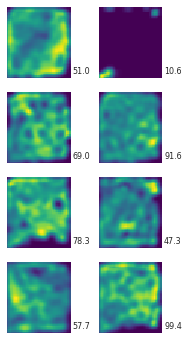

In [555]:
f = plt.figure(figsize=(3,6))
n_rows = 4
n_cols = 2
gs = f.add_gridspec(n_rows,n_cols)
ax = np.zeros((n_rows,n_cols), dtype=object)
cnt=0
for ii in range(n_rows):
    for jj in range(n_cols):
        ax[ii, jj] = f.add_subplot(gs[ii,jj])
        plot_fr_map2(*load_cell(sub_model_table.index[cnt], sub_model_table),ax=ax[ii,jj])
        cnt+=1

In [536]:
f.savefig(fig5_path / f'OF_Rasters_thr-{model}.png',dpi=300, bbox_inches='tight', pad_inches=0.2)

## Unit Metric Sig. Overlap

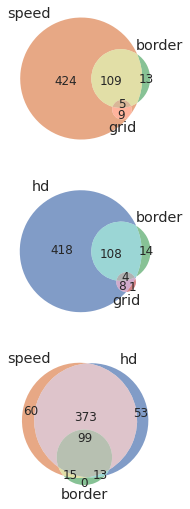

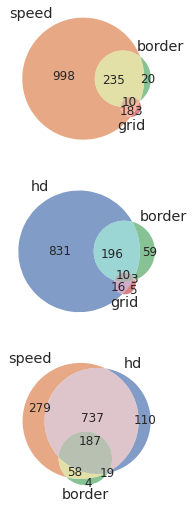

In [549]:

for unit_type in ['cell', 'mua']:
    set_counts = {}
    for analysis in analyses:
        unit_ids = set(metric_scores[(metric_scores['analysis_type']==analysis) & 
                                     (metric_scores['unit_type']==unit_type) & 
                                     (metric_scores['sig']==1) & 
                                     (metric_scores['session_valid'])].cl_name)
        set_counts[analysis] = unit_ids

    f,ax = plt.subplots(3,1, figsize=(4,9))
    sets = [['speed', 'border', 'grid'], ['hd', 'border', 'grid'], ['speed', 'hd', 'border']]
    type_color = {'hd': analyses_colors[0],
                  'speed': analyses_colors[1],
                  'border': analyses_colors[2],
                  'grid': analyses_colors[3]}

    for ii in range(3):
        set_lists = [set_counts[jj] for jj in sets[ii]]
        set_colors = [type_color[analysis] for analysis in sets[ii]]
        venn3(set_lists, set_labels=sets[ii], ax=ax[ii], alpha=0.7,set_colors=set_colors)

    # store
    f.savefig(fig5_path/(f'Venn_{unit_type}_Counts.pdf'), bbox_inches='tight')

## Units Metrics 

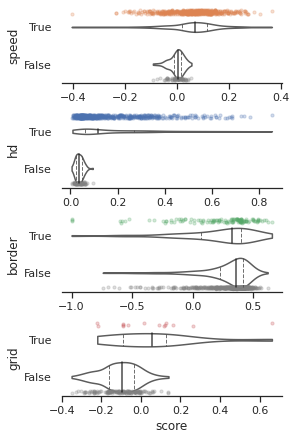

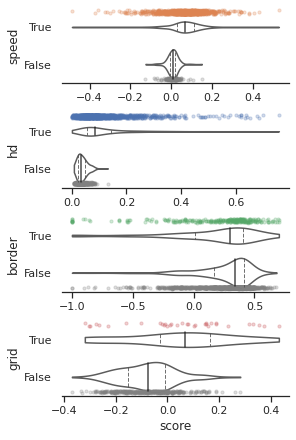

In [642]:

for unit_type in ['cell', 'mua']:

    analyses = ['speed', 'hd', 'border', 'grid']
    f, ax = plt.subplots(4,1, figsize=(4,6), constrained_layout=True)
    
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
                                        (metric_scores['analysis_type']==analysis) & 
                                        (metric_scores['session_valid']) ]
        data_subset = data_subset.astype({'sig': 'bool'})        
        data_subset = data_subset.astype({'sig': 'str'})

        sns.violinplot(data=data_subset, x='score', y='sig', order=['True', 'False'], color='white', cut=0, inner='quartile', linecolor='0.1', ax=ax[ii]) 
        
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
            
        sig_points = data_subset.sig=='True'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=-0.5 + 0.1*(np.random.rand(sig_points.sum())-0.5), s=10, color=type_color[analysis], alpha=0.25)
        
        sig_points = data_subset.sig=='False'
        ax[ii].scatter(x=data_subset['score'][sig_points], y=1.5 + 0.05*(np.random.rand(sig_points.sum())-0.5), s=10, color='grey', alpha=0.25)
#         data_subset_sig = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) & 
#                                         (metric_scores['sig']) &
#                                         (metric_scores['session_valid']) ]

#         sns.violinplot(data=data_subset_sig, x='score', color='white', cut=0, ax=ax[ii],  inner='quartile')  
#         #sns.boxplot(data=data_subset_sig, x='score', color='white', whis=100, ax=ax[ii])
#         sns.stripplot(data=data_subset_sig, x='score', color=type_color[analysis], alpha=0.5, ax=ax[ii])

#         data_subset = metric_scores[ (metric_scores['unit_type']==unit_type) & 
#                                         (metric_scores['analysis_type']==analysis) &
#                                         (metric_scores['session_valid']) ]

#         sns.stripplot(data=data_subset, x='score', color='grey', alpha=0.1, jitter=0.2, ax=ax[ii])
        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        if ii<3:
            ax[ii].set_xlabel('')
        #ax[ii].set_frame_on(False)
        ax[ii].get_xaxis().tick_bottom()

    f.savefig(fig5_path/(f'MetricsScores_{unit_type}.pdf'), bbox_inches='tight')

## Units Model Scores

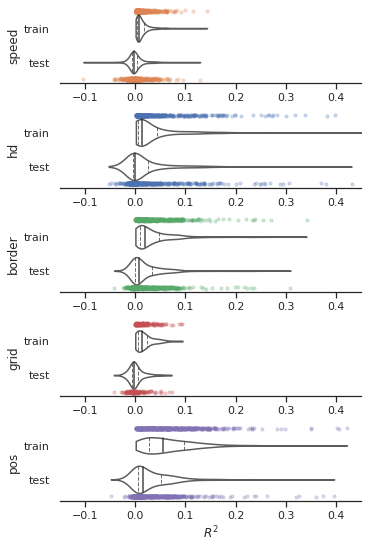

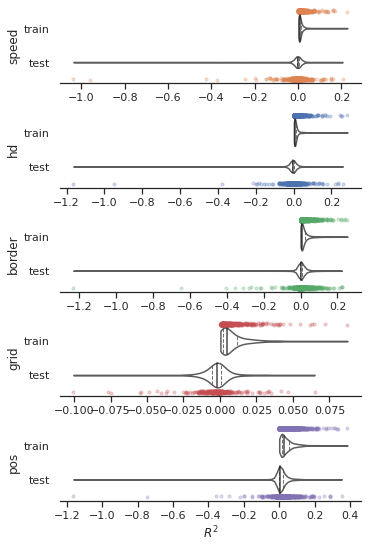

In [14]:
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}

metric='r2'
for unit_type in ['cell', 'mua']:
    analyses = ['speed', 'hd', 'border', 'grid', 'pos']
    f, ax = plt.subplots(5,1, figsize=(5,7.5), constrained_layout=True)
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                    (model_scores['model']==analysis) & 
                                    #(model_scores['split']==split) &
                                    (model_scores['metric']==metric) &
                                    (model_scores['session_valid']) 
                                  ]
        data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

        #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
        sns.violinplot(data=data_subset, x='value', y='split', color='white', cut=0, ax=ax[ii],  inner='quartile')  
        #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])
                
        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
            
        split_points = data_subset.split == 'train'
        ax[ii].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)
        
        split_points = data_subset.split == 'test'
        ax[ii].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)

        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].get_xaxis().tick_bottom()

        if metric=='r2':
            ax[ii].set_xlabel(r'$R^2$')
            if unit_type=='cell':
                ax[ii].set_xlim([-0.15,0.45])
        elif metric=='map_r':
            ax[ii].set_xlabel(r'$r_p[m,\hat{m}]$')
            ax[ii].set_xlim([-1,1])
        
        if ii<4:
            ax[ii].set_xlabel('')
    f.savefig(fig5_path/(f'ModelScores_{unit_type}_{metric}.pdf'), bbox_inches='tight')

## predicted map correlations

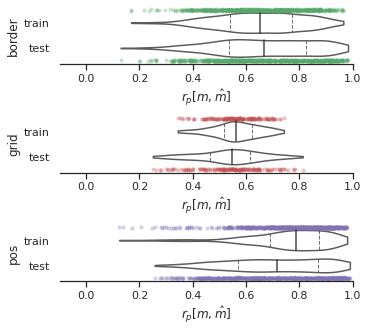

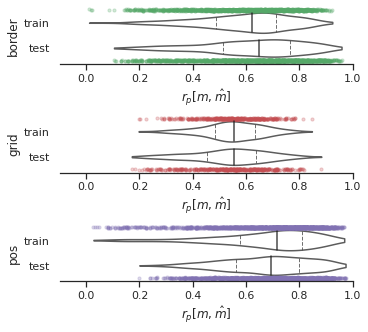

In [15]:
metric='map_r'
analyses = ['border', 'grid', 'pos']
for unit_type in ['cell', 'mua']:
    analyses = ['border', 'grid', 'pos']
    f, ax = plt.subplots(3,1, figsize=(5,4.5), constrained_layout=True)
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                    (model_scores['model']==analysis) & 
                                    #(model_scores['split']==split) &
                                    (model_scores['metric']==metric) &
                                    (model_scores['session_valid']) 
                                  ]
        data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

        sns.violinplot(data=data_subset, x='value', y='split', color='white', cut=0, ax=ax[ii],  inner='quartile')  
        #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)
            
        split_points = data_subset.split == 'train'
        ax[ii].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)
        
        split_points = data_subset.split == 'test'
        ax[ii].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)

        
        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].get_xaxis().tick_bottom()

        ax[ii].set_xlabel(r'$r_p[m,\hat{m}]$')
        ax[ii].set_xlim([-0.1,1])
                
    f.savefig(fig5_path/(f'ModelScores_{unit_type}_{metric}.pdf'), bbox_inches='tight')

model coefficients vs bins for speed and HD

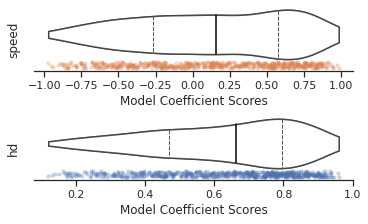

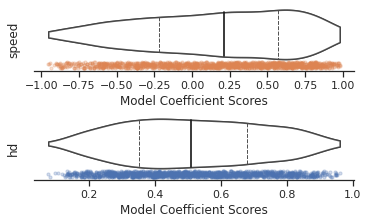

In [652]:
metric='map_r'
analyses = ['speed', 'hd']
split='train'
for unit_type in ['cell', 'mua']:
    f, ax = plt.subplots(2,1, figsize=(5,3), constrained_layout=True)
    sns.set_style('white')
    for ii, analysis in enumerate(analyses):
        data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                    (model_scores['model']==analysis) & 
                                    (model_scores['split']==split) &
                                    (model_scores['metric']==metric) &
                                    (model_scores['session_valid']) 
                                  ]
        data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

        #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
        sns.violinplot(data=data_subset, x='value',  color='white', cut=0, ax=ax[ii], inner='quartile') 
        #sns.stripplot(data=data_subset, x='value', color=type_color[analysis], alpha=0.2, ax=ax[ii])
        
        sns.violinplot(data=data_subset, x='value', color='white', cut=0, ax=ax[ii],  inner='quartile')  
        #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

        for l in ax[ii].lines:
            l.set_linestyle('--')
            l.set_linewidth(1)
            l.set_color('0.3')
            l.set_alpha(0.8)
        for l in ax[ii].lines[1::3]:
            l.set_linestyle('-')
            l.set_linewidth(1.5)
            l.set_color('0.1')
            l.set_alpha(0.8)
        for c in ax[ii].collections:
            c.set_edgecolor('0.2')
            c.set_alpha(0.8)

        n_ppints = data_subset.shape[0]
        ax[ii].scatter(x=data_subset['value'], y=0.5 + 0.1*(np.random.rand(n_ppints)-0.5),
                       s=10, color=type_color[analysis], alpha=0.25)



        ax[ii].set_ylabel(analysis)
        for pos in ['right', 'top', 'left']:
            ax[ii].spines[pos].set_visible(False)
        ax[ii].get_xaxis().tick_bottom()

        ax[ii].set_xlabel("Model Coefficient Scores")
    
    f.savefig(fig5_path/(f'ModelScores_{unit_type}_{metric}_sphd.pdf'), bbox_inches='tight')

## Pair plot between metric and model scores

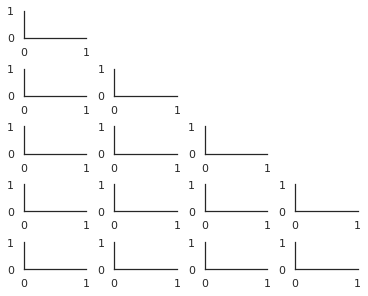

In [16]:
f = plt.figure(figsize=(5,4), constrained_layout=True)
n_rows = 5
n_cols = 4
gs = f.add_gridspec(n_rows,n_cols)
ax = np.zeros((n_rows,n_cols), dtype=object)
for ii in range(n_rows):
    for jj in range(ii+1):
        if jj<n_cols:
            ax[ii, jj] = f.add_subplot(gs[ii,jj])
            for pos in ['right', 'top']:
                ax[ii,jj].spines[pos].set_visible(False)
                #ax[ii].get_xaxis().tick_bottom()

In [18]:
model_metric = 'map_r'
split = 'train'

metric_types = ['speed', 'hd', 'border', 'grid']
models = ['speed', 'hd', 'border', 'grid', 'pos']

for ii in range(n_rows):
    model = models[ii]
    for jj in range(ii+1):
        if jj < n_cols:
            metric_type = metric_types[jj]
            ax[ii,jj].clear()
            if unit_type == 'all':
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) & 
                            (model_scores['session_valid'])][0]

                cl_names = model_scores[y_subset].cl_name
                x_subset = (metric_scores['analysis_type']==metric_type) & (metric_scores['cl_name'].isin(cl_names))
            else:
                y_subset =  [(model_scores['model']==model) & 
                            (model_scores['metric']==model_metric) & 
                            (model_scores['split']==split) &
                            (model_scores['unit_type']==unit_type) &
                            (model_scores['session_valid'])][0]

                cl_names = model_scores[y_subset].cl_name
                x_subset = (metric_scores['analysis_type']==metric_type) & (metric_scores['cl_name'].isin(cl_names))

            joint_data = model_scores.loc[y_subset, ['subject', 'unit_type', 'model', 'value']].copy()
            joint_data.loc[:, 'y_var'] = joint_data['value'].values.astype(float)
            joint_data.loc[:, 'x_var'] = metric_scores.loc[x_subset, 'score'].values.astype(float)
            joint_data.dropna(inplace=True)
            
            sns.scatterplot(data=joint_data,x='x_var', y='y_var', color='k', alpha=0.2, size=2, legend=False, ax=ax[ii,jj])
                        
            if model_metric=='r2':
                ax[ii,jj].set_ylim([-0.05, 0.45])
            elif model_metric=='map_r':
                ax[ii,jj].set_ylim([-0.02, 1])    
            
            if metric_type=='speed':
                ax[ii,jj].set_xlim([-0.5, .5])    
            elif metric_type=='hd':
                ax[ii,jj].set_xlim([-0.02, 1])    
            elif metric_type=='border':
                ax[ii,jj].set_xlim([-1, 1])
            elif metric_type=='grid':
                ax[ii,jj].set_xlim([-0.75, 0.75])
                
            xmax = ax[ii,jj].get_xlim()[1]
            ymax = ax[ii,jj].get_ylim()[1]
            
            ax[ii,jj].set_xticklabels('')
            ax[ii,jj].set_yticklabels('')

            ax[ii,jj].set_xlabel('')
            ax[ii,jj].set_ylabel('')
                
            if jj==0:
                ax[ii,jj].set_ylabel(model)
                ax[ii,jj].set_yticks([0, ymax])
                ax[ii,jj].set_yticklabels([0, ymax])
                ax[ii,jj].get_yaxis().tick_left()

            if ii==(n_rows-1):
                ax[ii,jj].set_xlabel(metric_type)
                ax[ii,jj].set_xticks([0, xmax])
                ax[ii,jj].set_xticklabels([0, xmax])
                ax[ii,jj].get_xaxis().tick_bottom()
                
            ax[ii,jj].spines['left'].set_color(type_color[model])
            ax[ii,jj].spines['left'].set_linewidth(2)
            ax[ii,jj].spines['bottom'].set_color(type_color[metric_type])
            ax[ii,jj].spines['bottom'].set_linewidth(2)
            
f.savefig(fig5_path/(f'ModelvMetric_{unit_type}_{model_metric}_{split}.pdf'), bbox_inches='tight')

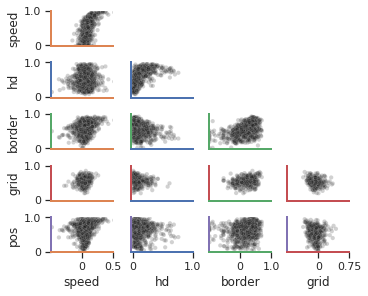

In [19]:
f

## Example Model Fits

In [21]:
@interact(model=['speed','hd','border','grid', 'pos'], thr=widgets.FloatSlider(min=-1, max=1, step=0.02), unit_type=['cell', 'mua', None], model_metric=['r2', 'map_r', 'n_err'], split=['train', 'test'] )
def model_filter_units(model, thr, model_metric, split, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model)
                                      & (model_scores.metric==model_metric)
                                      & (model_scores.split==split) 
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]

    return sub_table.sort_values(by=['value'], ascending=False)

interactive(children=(Dropdown(description='model', options=('speed', 'hd', 'border', 'grid', 'pos'), value='s…

In [27]:
from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)
subject = 'Cl'
session = 'Cl_OF_013119'
session_info = si.SubjectSessionInfo(subject, session)


In [28]:
session_info.get_encoding_model('speed')

{'speed': <bound method SpatialEncodingModels.get_speed_model of <Analyses.spatial_functions.SpatialEncodingModels object at 0x7f7b8da52c88>>}

In [655]:
class Foo:
    def bar(self, a):
        print(a)
        
foo = Foo()
hasattr(foo, 'bar')

True

## Vennn Diagram for Overlap between task and open field identification of units.

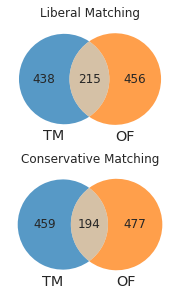

In [466]:
n_TM_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='T3')].shape[0]
n_OF_cells = unit_table[(unit_table.unit_type=='cell') & (unit_table.task2=='OF')].shape[0]

n_matches_lib = unit_table.match_lib_multi_task_id.max()+1 
n_matches_con = unit_table.match_con_multi_task_id.max()+1

f, ax = plt.subplots(2,1,constrained_layout=True)
venn2( (n_TM_cells-n_matches_lib, n_OF_cells-n_matches_lib, n_matches_lib), set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[0])
venn2( (n_TM_cells-n_matches_con, n_OF_cells-n_matches_con, n_matches_con), set_labels=['TM', 'OF'], set_colors=colors[:2], alpha=0.75, ax=ax[1])
ax[0].set_title("Liberal Matching")
ax[1].set_title("Conservative Matching")
f.savefig(fig5_path/(f'ClusterMatchesXTasks.pdf'), bbox_inches='tight')